In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from dataclasses import replace
from functools import partial

from copy import deepcopy, copy

import vtk
from vtk.util import numpy_support

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

from rattlers import *

def jax_copy(x):
    return jax.tree.map(lambda y: y, x)

In [ ]:
def build_microstate(N, phi, dim, e_int, dt):
    # assign bidisperse radii
    rad = jnp.ones(N)
    rad = rad.at[: N // 2].set(0.5)
    rad = rad.at[N // 2:].set(0.7)
    
    # set the box size for the packing fraction and the radii
    volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
    L = (jnp.sum(volume) / phi) ** (1 / dim)
    box_size = jnp.ones(dim) * L

    # create microstate
    key = jax.random.PRNGKey(np.random.randint(0, 1000000))
    pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
    mass = jnp.ones(N)
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    
    # create system and state
    state = jd.State.create(pos=pos, rad=rad, mass=mass, volume=volume)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="linearfire",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )

    state, system, _, _ = jd.minimizers.minimize(state, system)

    return state, system


states, systems = [], []
for N in [5, 10, 20, 50]:
    state, system = build_microstate(N=N, phi=0.4, dim=2, e_int=1.0, dt=1e-2)
    states.append(state)

    systems.append(
        jd.System.create(
            state_shape=state.shape,
            dt=1e-2,
            linear_integrator_type="verlet",
            domain_type="periodic",
            force_model_type="spring",
            collider_type="naive",
            mat_table=system.mat_table,
            domain_kw=dict(
                box_size=system.domain.box_size,
            ),
        )
    )

jax.vmap(lambda st, sy: sy.step(st, sy, n=100))(states, systems)

ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [294]:
base_system = replace(system)
base_state = replace(state)

In [295]:
_system = jd.System.create(
    state_shape=base_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    # collider_type="celllist",
    # collider_kw=dict(state=base_state),
    mat_table=base_system.mat_table,
    domain_kw=dict(
        box_size=base_system.domain.box_size,
    ),
)

target_temperature = 1e-4
seed = np.random.randint(0, 1000000)
_state, _system = scale_by_packing_fraction_offset(base_state, _system, -1e-1, copy=True)
_state = set_temperature(base_state, target_temperature, seed, dof_disk, True)

n_repeats = 100
ke = np.zeros(n_repeats)
pe = np.zeros(n_repeats)
for i in range(n_repeats):
    n_steps = 100
    _state, _system = _system.step(_state, _system, n=n_steps)
    ke_t = 0.5 * (_state.mass * jnp.sum(_state.vel ** 2, axis=-1))
    ke[i] = jnp.sum(ke_t)
    pe[i] = jnp.sum(_system.collider.compute_potential_energy(_state, _system))

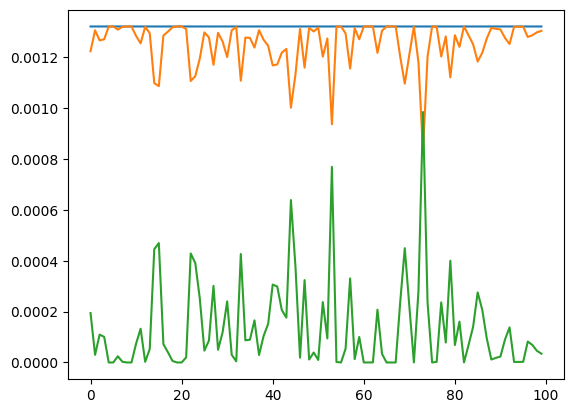

In [296]:
plt.plot(ke + pe / 2)
plt.plot(ke)
plt.plot(pe)

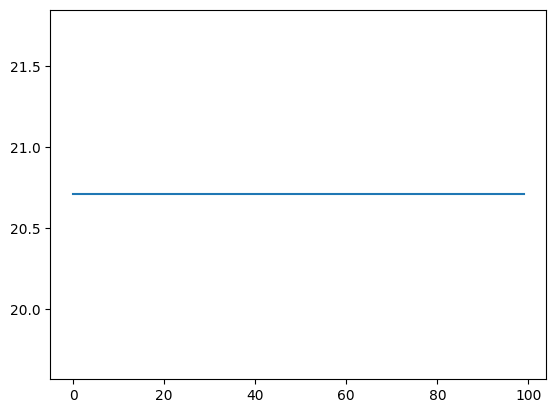

In [239]:
plt.plot(pe)

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from functools import partial

import vtk
from vtk.util import numpy_support

import jaxdem as jd

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

def calculate_packing_fraction(state, system):
    volume = jnp.sum(jnp.pi * state.rad ** 2)
    return jnp.sum(volume) / jnp.prod(system.domain.box_size)

def jax_copy(x):
    return jax.tree.map(lambda y: y, x)

def scale_by_packing_fraction_offset(state, system, offset, copy=False):
    """
    Scale the state and system to packing fraction + offset.
    Optionally return a copy of the state and system.
    """
    if copy:
        new_state = jax_copy(state)
        new_system = jax_copy(system)
    else:
        new_state = state
        new_system = system

    packing_fraction = calculate_packing_fraction(new_state, new_system)
    scale = (packing_fraction / (packing_fraction + offset)) ** (1 / state.dim)
    new_state.pos_c *= scale
    new_system.domain.box_size *= scale
    return new_state, new_system

def calculate_kinetic_energy(state):
    """
    Calculate the kinetic energy for each particle.
    """
    ke_t = 0.5 * state.mass * jnp.sum(state.vel ** 2, axis=-1)
    ke_r = 0.5 * jnp.sum(state.inertia * state.angVel ** 2, axis=-1)
    return ke_t + ke_r

def dof_disk(state):  # TODO: account for state.fixed!
    return state.dim * state.N

def dof_rod(state):  # TODO: account for state.fixed!
    return state.dim * state.N + state.inertia.shape[1] * state.N

def dof_rigid_clump(state):  # TODO: account for state.fixed!
    N_clumps = jnp.max(state.ID) + 1
    return state.dim * N_clumps + state.inertia.shape[1] * N_clumps

def calculate_temperature(state, dof_func):
    ke = jnp.sum(calculate_kinetic_energy(state))
    return 2 * ke / dof_func(state)

def set_temperature(state, target_temperature, seed, dof_func, subtract_mean_velocities=True):
    key = jax.random.PRNGKey(seed)
    key_vel, key_angVel = jax.random.split(key, 2)
    state.vel = jax.random.normal(key_vel, state.vel.shape)
    if subtract_mean_velocities:
        state.vel -= jnp.mean(state.vel, axis=0)
    state.angVel = jax.random.normal(key_angVel, state.angVel.shape)
    temperature = calculate_temperature(state, dof_func)
    scale = jnp.sqrt(target_temperature / temperature)
    state.vel *= scale
    state.angVel *= scale
    temperature = calculate_temperature(state, dof_func)
    assert jnp.isclose(temperature, target_temperature)
    return state


N_systems = 1
N = 100
phi = 0.4
dim = 2
e_int = 1.0
dt = 1e-2

def build_microstate(i):
    # assign bidisperse radii
    rad = jnp.ones(N)
    rad = rad.at[: N // 2].set(0.5)
    rad = rad.at[N // 2:].set(0.7)
    
    # set the box size for the packing fraction and the radii
    volume = (jnp.pi ** (dim / 2) / jax.scipy.special.gamma(dim / 2 + 1)) * rad ** dim
    L = (jnp.sum(volume) / phi) ** (1 / dim)
    box_size = jnp.ones(dim) * L

    # create microstate
    key = jax.random.PRNGKey(np.random.randint(0, 1000000))
    pos = jax.random.uniform(key, (N, dim), minval=0.0, maxval=L)
    mass = jnp.ones(N)
    mats = [jd.Material.create("elastic", young=e_int, poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    
    # create system and state
    state = jd.State.create(pos=pos, rad=rad, mass=mass)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="linearfire",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=box_size,
        ),
    )
    return state, system

T_0 = 1e-5
T_f = 1.1e-5
N_T = 10

phi_0 = 1e-8
phi_f = 1e-1
N_phi = 10

state, system = build_microstate(0)
ic_state, ic_system, final_pf, final_pe = jd.utils.jamming.bisection_jam(state, system)

base_state = jax_copy(ic_state)
base_system = jd.System.create(
    state_shape=base_state.shape,
    dt=dt,
    linear_integrator_type="verlet",
    domain_type="periodic",
    force_model_type="spring",
    collider_type="naive",
    mat_table=system.mat_table,
    domain_kw=dict(
        box_size=system.domain.box_size,
    )
)



Step: 1 -  phi=0.3441187958743682, PE=0.0
Step: 2 -  phi=0.3451187958743682, PE=0.0
Step: 3 -  phi=0.3461187958743682, PE=0.0
Step: 4 -  phi=0.3471187958743682, PE=0.0
Step: 5 -  phi=0.3481187958743682, PE=0.0
Step: 6 -  phi=0.3491187958743682, PE=0.0
Step: 7 -  phi=0.3501187958743682, PE=0.0
Step: 8 -  phi=0.35111879587436823, PE=0.0
Step: 9 -  phi=0.35211879587436823, PE=0.0
Step: 10 -  phi=0.35311879587436823, PE=0.0
Step: 11 -  phi=0.35411879587436823, PE=0.0
Step: 12 -  phi=0.35511879587436823, PE=0.0
Step: 13 -  phi=0.35611879587436823, PE=0.0
Step: 14 -  phi=0.35711879587436823, PE=0.0
Step: 15 -  phi=0.35811879587436823, PE=0.0
Step: 16 -  phi=0.35911879587436824, PE=0.0
Step: 17 -  phi=0.36011879587436824, PE=8.067752250044493e-17
Step: 18 -  phi=0.36111879587436824, PE=0.0
Step: 19 -  phi=0.36211879587436824, PE=0.0
Step: 20 -  phi=0.36311879587436824, PE=0.0
Step: 21 -  phi=0.36411879587436824, PE=0.0
Step: 22 -  phi=0.36511879587436824, PE=0.0
Step: 23 -  phi=0.366118795874

In [39]:
for phi_offset in -np.logspace(np.log10(phi_0), np.log10(phi_f), N_phi):
    base_state, base_system = scale_by_packing_fraction_offset(base_state, base_system, phi_offset, False)

    state = jd.State.stack([
        set_temperature(
            jax_copy(base_state),
            T,
            np.random.randint(0, 1e9),
            dof_disk,
            True
        ) for T in np.linspace(T_0, T_f, N_T)
    ])

    system = jd.System.stack([
        jd.System.create(
            state_shape=base_state.shape,
            dt=dt,
            linear_integrator_type="verlet",
            domain_type="periodic",
            force_model_type="spring",
            collider_type="naive",
            mat_table=system.mat_table,
            domain_kw=dict(
                box_size=system.domain.box_size.copy(),
            )
        ) for _ in range(N_T)
    ])



    break

In [40]:
n_repeats = 100
ke = np.zeros((n_repeats, state.batch_size))
pe = np.zeros((n_repeats, state.batch_size))
for i in range(n_repeats):
    n_steps = 100
    state, system = system.step(state, system, n=n_steps)
    ke[i] = jnp.sum(0.5 * (state.mass * jnp.sum(state.vel ** 2, axis=-1)), axis=-1)
    pe[i] = jnp.sum(jax.vmap(lambda st, sy: sy.collider.compute_potential_energy(st, sy))(state, system), axis=-1)

ValueError: Incompatible shapes for broadcasting: shapes=[(10,), (10, 2)]

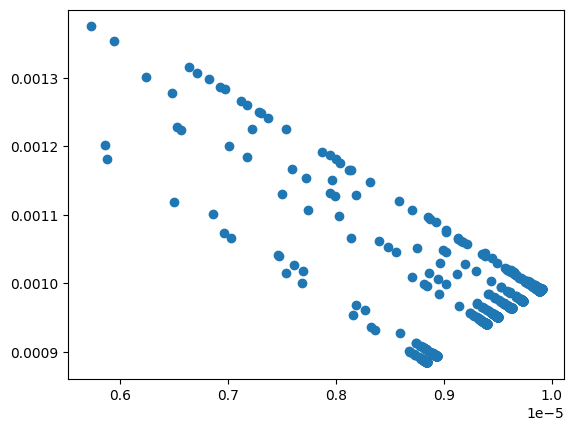

In [31]:
temp = 2 * ke / (state.N * state.dim)

plt.scatter(temp.flatten(), (pe + ke).flatten())